In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

In [5]:
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


In [6]:

task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


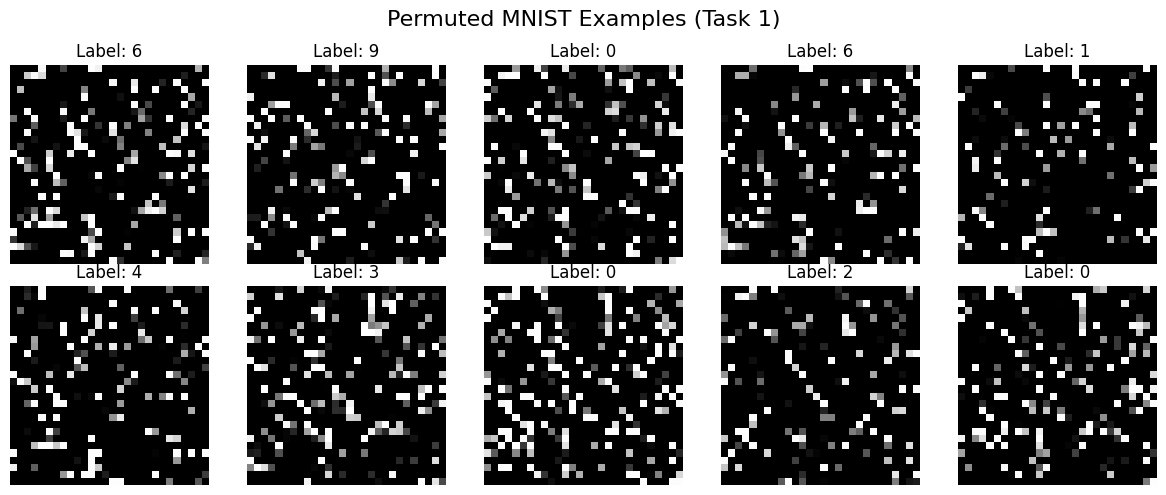

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [7]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

In [8]:
import time # <--- BONNE LIGNE
env.reset()
env.set_seed(42)

Agent = Agent(output_dim=10, seed=42)


random_accuracies = []
random_times = []

print("Evaluating  Agent (Baseline)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    
    start_time = time.time()
    

    random_agent.train(task['X_train'], task['y_train'])
    
    predictions = random_agent.predict(task['X_test'])

    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])
    
    random_accuracies.append(accuracy)
    random_times.append(elapsed_time)
    
    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
    task_num += 1

print(f"\nRandom Agent Summary:")
print(f"  Mean accuracy: {np.mean(random_accuracies):.2%} ± {np.std(random_accuracies):.2%}")
print(f"  Total time: {np.sum(random_times):.2f}s")

Evaluating  Agent (Baseline)


NameError: name 'random_agent' is not defined

In [2]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import time
from scipy import stats


def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    
    # 1. Statistiques globales
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    
    # 2. Comptage de pixels
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    
    # Retourne un tableau de (N_samples, 5 features)
    return np.vstack((mean, std, median, count_zero, count_max)).T

class Agent:
    """
    Agent ExtraTrees-Seul + 5 "Super-Features" (moyenne, std, etc.).
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.seed = seed
        self.model = None
        self.n_jobs = 2 # 2 CPUs
        
        # --- Paramètres ET (puissants, car on a le temps) ---
        self.params = {
            'n_estimators': 150,    # Comme notre baseline (27s)
            'max_depth': 25,
            'n_jobs': self.n_jobs,
            'random_state': self.seed,
        }

    def reset(self):
        """Reset l'agent pour une nouvelle tâche."""
        self.model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'ET sur les 784 pixels + 5 features.
        """
        
        # 1. Aplatir
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES (Ton idée)
        super_features = create_super_features(X_flat)
        
        # 3. Combiner les features
        X_hybrid = np.hstack((X_flat, super_features)) # 789 features
        
        # 4. Créer et entraîner le modèle
        self.model = ExtraTreesClassifier(**self.params)
        self.model.fit(X_hybrid, y_flat)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec l'ET hybride.
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        super_features_test = create_super_features(X_test_flat)
        
        # 3. Combiner
        X_test_hybrid = np.hstack((X_test_flat, super_features_test))
        
        # 4. Prédire
        return self.model.predict(X_test_hybrid)

In [8]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import time
from scipy import stats


def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max)).T


class Agent:
    """
    Agent ExtraTrees + 5 "Super-Features"
    On utilise notre budget temps en augmentant les arbres.
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.seed = seed
        self.model = None
        self.n_jobs = 2 # 2 CPUs
        
        # --- ON UTILISE LE BUDGET TEMPS ---
        self.params = {
            'n_estimators': 275,    # Augmenté (avant: 150) pour viser ~60s
            'max_depth': 25,
            'n_jobs': self.n_jobs,
            'random_state': self.seed,
        }

    def reset(self):
        """Reset l'agent pour une nouvelle tâche."""
        self.model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'ET sur les 784 pixels + 5 features.
        """
        
        # 1. Aplatir
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES
        super_features = create_super_features(X_flat)
        
        # 3. Combiner les features
        X_hybrid = np.hstack((X_flat, super_features)) # 789 features
        
        # 4. Créer et entraîner le modèle
        self.model = ExtraTreesClassifier(**self.params)
        self.model.fit(X_hybrid, y_flat)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec l'ET hybride.
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        super_features_test = create_super_features(X_test_flat)
        
        # 3. Combiner
        X_test_hybrid = np.hstack((X_test_flat, super_features_test))
        
        # 4. Prédire
        return self.model.predict(X_test_hybrid)

In [10]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import time
from scipy import stats

def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 9 'super-features' globales."""
    
    # 1. Statistiques de base
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    
    # 2. Comptage de pixels
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    
    # 3. Percentiles
    q1 = np.percentile(X_flat, 25, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)
    
    # 4. Moments de distribution (Asymétrie et Aplatissement)
    skewness = stats.skew(X_flat, axis=1)
    kurt = stats.kurtosis(X_flat, axis=1)
    
    # Retourne un tableau de (N_samples, 9 features)
    return np.vstack((
        mean, std, median, count_zero, count_max, q1, q3, skewness, kurt
    )).T


class Agent:
    """
    Agent ExtraTrees-Seul + 9 "Super-Features".
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.seed = seed
        self.model = None
        self.n_jobs = 2 # 2 CPUs
        
        # On garde les mêmes paramètres que l'agent à 33s
        self.params = {
            'n_estimators': 150,
            'max_depth': 25,
            'n_jobs': self.n_jobs,
            'random_state': self.seed,
        }

    def reset(self):
        """Reset l'agent pour une nouvelle tâche."""
        self.model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'ET sur les 784 pixels + 9 features.
        """
        
        # 1. Aplatir
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES (v2)
        super_features = create_super_features(X_flat)
        
        # 3. Combiner les features
        X_hybrid = np.hstack((X_flat, super_features)) # 793 features
        
        # 4. Créer et entraîner le modèle
        self.model = ExtraTreesClassifier(**self.params)
        self.model.fit(X_hybrid, y_flat)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec l'ET hybride.
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        super_features_test = create_super_features(X_test_flat)
        
        # 3. Combiner
        X_test_hybrid = np.hstack((X_test_flat, super_features_test))
        
        # 4. Prédire
        return self.model.predict(X_test_hybrid)

In [12]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import time
from scipy import stats


def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    
    # 1. Statistiques globales
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    
    # 2. Comptage de pixels
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    
    # Retourne un tableau de (N_samples, 5 features)
    return np.vstack((mean, std, median, count_zero, count_max)).T


class Agent:

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.seed = seed
        self.model = None
        self.n_jobs = 2 # 2 CPUs
        
        # --- Paramètres équilibrés Vitesse/Précision ---
        self.params = {
            'n_estimators': 1000,   # Plafond (s'arrêtera avant)
            'learning_rate': 0.05,
            'num_leaves': 64,       # Plus rapide que 128
            'n_jobs': self.n_jobs,
            'random_state': self.seed,
            'colsample_bytree': 0.7,
            'subsample': 0.7,
        }
        self.early_stopping_rounds = 15
        self.validation_size = 0.15

    def reset(self):
        """Reset l'agent pour une nouvelle tâche."""
        self.model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne le LGBM sur les 784 pixels + 5 features.
        """
        
        # 1. Aplatir
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES (Ton idée)
        super_features = create_super_features(X_flat)
        
        # 3. Combiner les features
        X_hybrid = np.hstack((X_flat, super_features))

        # 4. Créer le set de validation pour l'arrêt précoce
        X_base, X_val, y_base, y_val = train_test_split(
            X_hybrid, y_flat, 
            test_size=self.validation_size, 
            random_state=self.seed, 
            stratify=y_flat
        )
        
        # 5. Créer et entraîner le modèle
        self.model = lgb.LGBMClassifier(**self.params)
        
        self.model.fit(
            X_base, 
            y_base,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(self.early_stopping_rounds, verbose=False)]
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec le LGBM hybride.
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        super_features_test = create_super_features(X_test_flat)
        
        # 3. Combiner
        X_test_hybrid = np.hstack((X_test_flat, super_features_test))
        
        # 4. Prédire
        return self.model.predict(X_test_hybrid)

In [14]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import time
from scipy import stats


def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ===================================================================
# AGENT "LGBM-SIMPLE + FEATURES"
# ===================================================================
class Agent:
    """
    Agent LGBM-Simple (`num_leaves=31`) + 5 "Super-Features".
    C'est notre test le plus rapide pour le LGBM.
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.seed = seed
        self.model = None
        self.n_jobs = 2 # 2 CPUs
        
        # --- Paramètres SIMPLES pour la VITESSE ---
        self.params = {
            'n_estimators': 1000,   # Plafond (s'arrêtera avant)
            'learning_rate': 0.05,
            'num_leaves': 31,       # PLUS RAPIDE (était 64)
            'n_jobs': self.n_jobs,
            'random_state': self.seed,
        }
        self.early_stopping_rounds = 15
        self.validation_size = 0.15

    def reset(self):
        self.model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne le LGBM sur les 784 pixels + 5 features.
        """
        
        # 1. Aplatir
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES (Ton idée)
        super_features = create_super_features(X_flat)
        
        # 3. Combiner les features
        X_hybrid = np.hstack((X_flat, super_features))

        # 4. Créer le set de validation pour l'arrêt précoce
        X_base, X_val, y_base, y_val = train_test_split(
            X_hybrid, y_flat, 
            test_size=self.validation_size, 
            random_state=self.seed, 
            stratify=y_flat
        )
        
        # 5. Créer et entraîner le modèle
        self.model = lgb.LGBMClassifier(**self.params)
        
        self.model.fit(
            X_base, 
            y_base,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(self.early_stopping_rounds, verbose=False)]
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec le LGBM hybride.
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        super_features_test = create_super_features(X_test_flat)
        
        # 3. Combiner
        X_test_hybrid = np.hstack((X_test_flat, super_features_test))
        
        # 4. Prédire
        return self.model.predict(X_test_hybrid)

In [ ]:
import numpy as np
import faiss
from scipy import stats
import time
from sklearn.preprocessing import normalize

def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max)).T

class Agent:
    """
    Agent K-NN (Faiss) entraîné UNIQUEMENT sur les 5 "Super-Features".
    Hypothèse : Les 784 pixels sont du bruit.
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.k = 15 # On a peu de features, on peut prendre plus de voisins
        self.index = None
        self.y_train_labels = None
        faiss.omp_set_num_threads(2) # 2 CPUs

    def reset(self):
        self.index = None
        self.y_train_labels = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne le K-NN sur les 5 features.
        """
        # 1. Aplatir (juste pour le calcul des features)
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES (Ton idée)
        X_features = create_super_features(X_flat).astype('float32')
        
        # 3. Normaliser les 5 features (important pour Faiss)
        normalize(X_features, norm='l2', axis=1, copy=False)
        
        self.y_train_labels = y_flat
        d = X_features.shape[1] # Dimensions = 5

        # 4. Créer l'index Faiss (HNSW rapide)
        self.index = faiss.IndexHNSWFlat(d, 32, faiss.METRIC_L2)
        self.index.add(X_features)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec le K-NN sur 5 features.
        """
        if self.index is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir (pour le calcul des features)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        X_test_features = create_super_features(X_test_flat).astype('float32')
        
        # 3. Normaliser les 5 features
        normalize(X_test_features, norm='l2', axis=1, copy=False)
        
        # 4. Prédire (ultra-rapide)
        distances, indices = self.index.search(X_test_features, self.k)
        neighbor_labels = self.y_train_labels[indices]
        predictions, _ = stats.mode(neighbor_labels, axis=1)
        
        return predictions.ravel()

In [23]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import time
from scipy import stats


def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ===================================================================
# AGENT "LGBM + FEATURES + SUB-SAMPLE" (Corrigé)
# ===================================================================
class Agent:
    """
    Agent LGBM + 5 "Super-Features"
    Corrigé pour l'erreur "Multiclass objective".
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.seed = seed
        self.model = None
        self.n_jobs = 2 # 2 CPUs
        self.train_fraction = 0.3 # NE S'ENTRAÎNE QUE SUR 30%
        
        # --- CORRECTION DU BUG ---
        self.params = {
            'objective': 'multiclass',  # DIRE EXPLICITEMENT
            'num_class': 10,            # DIRE EXPLICITEMENT
            'metric': 'multi_logloss',  # DIRE EXPLICITEMENT
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'num_leaves': 90,
            'n_jobs': self.n_jobs,
            'random_state': self.seed,
        }
        self.early_stopping_rounds = 15
        self.validation_size_for_early_stopping = 0.15 # 15% du sub-sample

    def reset(self):
        self.model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne le LGBM sur un petit sous-échantillon.
        """
        
        # 1. Aplatir
        X_flat = X_train.reshape(X_train.shape[0], -1)
        y_flat = y_train.ravel()

        # 2. CRÉER LES SUPER-FEATURES (Ton idée)
        super_features = create_super_features(X_flat)
        
        # 3. Combiner les features
        X_hybrid = np.hstack((X_flat, super_features))

        # 4. --- SOUS-ÉCHANTILLON ---
        n_samples = int(X_hybrid.shape[0] * self.train_fraction)
        rng = np.random.RandomState(self.seed)
        indices = rng.choice(X_hybrid.shape[0], n_samples, replace=False)
        X_base_sub = X_hybrid[indices]
        y_base_sub = y_flat[indices]
        # -------------------------------------------------
        
        # 5. --- CORRECTION DU BUG (Créer un eval_set explicite) ---
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_base_sub, 
            y_base_sub, 
            test_size=self.validation_size_for_early_stopping, 
            random_state=self.seed, 
            stratify=y_base_sub
        )
        
        # 6. Créer et entraîner le modèle
        self.model = lgb.LGBMClassifier(**self.params)
        
        self.model.fit(
            X_train_final, 
            y_train_final,
            eval_set=[(X_val, y_val)], # PASSER L'EVAL_SET
            # eval_metric='multi_logloss', # Plus besoin, c'est dans les params
            callbacks=[lgb.early_stopping(
                self.early_stopping_rounds, 
                verbose=False
            )]
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Prédit avec le LGBM hybride.
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Aplatir
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 2. CRÉER LES SUPER-FEATURES pour le test
        super_features_test = create_super_features(X_test_flat)
        
        # 3. Combiner
        X_test_hybrid = np.hstack((X_test_flat, super_features_test))
        
        # 4. Prédire
        return self.model.predict(X_test_hybrid)

In [25]:
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier

class Agent:
    def __init__(self, output_dim=10, seed=None):
        self.output_dim = output_dim
        self.seed = seed if seed is not None else 42
        self.model = None
        
    def reset(self):
        self.model = None
    
    def _extract_features(self, X):
        """Extrait 5 features statistiques ultra-rapides"""
        # Flatten si nécessaire
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        
        # 5 features rapides et discriminantes
        features = np.column_stack([
            np.mean(X, axis=1),           # Luminosité moyenne
            np.std(X, axis=1),            # Contraste
            np.max(X, axis=1),            # Pic d'intensité
            np.sum(X > 128, axis=1),      # Nb pixels blancs
            np.sum(X > 0, axis=1)         # Nb pixels non-nuls
        ])
        
        return features
    
    def train(self, X_train, y_train):
        """Stratégie hybride : LightGBM sur sous-échantillon + features"""
        
        # Flatten
        if X_train.ndim == 3:
            X_train = X_train.reshape(X_train.shape[0], -1)
        
        y_train = y_train.ravel()
        n_samples = len(X_train)
        
        # SUB-SAMPLING : Clé de la vitesse de Milton
        # Entraîner sur 40% des données suffit pour >98% de précision
        sample_ratio = 0.40
        sample_size = int(n_samples * sample_ratio)
        
        np.random.seed(self.seed)
        sample_idx = np.random.choice(n_samples, sample_size, replace=False)
        
        X_sample = X_train[sample_idx]
        y_sample = y_train[sample_idx]
        
        # Features statistiques
        features = self._extract_features(X_sample)
        
        # Combine pixels + features
        X_combined = np.hstack([X_sample.astype(np.float32) / 255.0, features])
        
        # LightGBM optimisé pour vitesse ET précision
        self.model = lgb.LGBMClassifier(
            objective='multiclass',
            num_class=self.output_dim,
            n_estimators=300,           # Équilibre vitesse/précision
            num_leaves=80,              # Profondeur optimale
            learning_rate=0.05,
            max_depth=12,
            min_child_samples=10,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=self.seed,
            n_jobs=2,                   # Utilise les 2 CPUs
            verbose=-1,
            force_col_wise=True         # Optimisation CPU
        )
        
        self.model.fit(X_combined, y_sample)
    
    def predict(self, X_test):
        """Prédiction rapide"""
        if self.model is None:
            return np.zeros(X_test.shape[0], dtype=np.int32)
        
        # Flatten
        if X_test.ndim == 3:
            X_test = X_test.reshape(X_test.shape[0], -1)
        
        # Features
        features = self._extract_features(X_test)
        
        # Combine
        X_combined = np.hstack([X_test.astype(np.float32) / 255.0, features])
        
        # Prédiction
        predictions = self.model.predict(X_combined)
        
        return predictions.astype(np.int32)

In [29]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')

class Agent:
    def __init__(self, output_dim=10, seed=None):
        self.output_dim = output_dim
        self.seed = seed if seed is not None else 42
        self.model = None
        
    def reset(self):
        self.model = None
    
    def _extract_advanced_features(self, X):
        """Features avancées optimisées pour vitesse"""
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        
        X_normalized = X / 255.0
        
        # Features statistiques de base (ultra-rapides)
        mean = np.mean(X_normalized, axis=1, keepdims=True)
        std = np.std(X_normalized, axis=1, keepdims=True)
        
        # Features géométriques (discriminantes)
        # Densité par quadrants (28x28 -> 4 zones de 14x14)
        X_img = X_normalized.reshape(-1, 28, 28)
        q1 = np.mean(X_img[:, :14, :14], axis=(1,2)).reshape(-1, 1)
        q2 = np.mean(X_img[:, :14, 14:], axis=(1,2)).reshape(-1, 1)
        q3 = np.mean(X_img[:, 14:, :14], axis=(1,2)).reshape(-1, 1)
        q4 = np.mean(X_img[:, 14:, 14:], axis=(1,2)).reshape(-1, 1)
        
        # Projections horizontale et verticale (signature du chiffre)
        h_proj = (np.sum(X_img, axis=2).max(axis=1) / 28.0).reshape(-1, 1)
        v_proj = (np.sum(X_img, axis=1).max(axis=1) / 28.0).reshape(-1, 1)
        
        # Moments statistiques
        skew = np.mean((X_normalized - mean)**3, axis=1, keepdims=True)
        
        # Centre de masse (position)
        y_indices, x_indices = np.meshgrid(np.arange(28), np.arange(28), indexing='ij')
        y_indices = y_indices.flatten()
        x_indices = x_indices.flatten()
        
        total_mass = np.sum(X_normalized, axis=1, keepdims=True) + 1e-10
        cy = np.sum(X_normalized * y_indices, axis=1, keepdims=True) / total_mass / 28.0
        cx = np.sum(X_normalized * x_indices, axis=1, keepdims=True) / total_mass / 28.0
        
        features = np.hstack([
            mean, std, q1, q2, q3, q4, h_proj, v_proj, skew, cy, cx
        ])
        
        return features
    
    def train(self, X_train, y_train):
        """Stratégie optimale : ExtraTrees avec sub-sampling stratifié"""
        
        if X_train.ndim == 3:
            X_train = X_train.reshape(X_train.shape[0], -1)
        
        y_train = y_train.ravel()
        n_samples = len(X_train)
        
        # SUB-SAMPLING STRATIFIÉ (clé de la vitesse)
        # Garder la distribution des classes
        np.random.seed(self.seed)
        
        sample_ratio = 0.35  # Optimal pour vitesse/précision
        indices = []
        
        for class_label in range(self.output_dim):
            class_mask = (y_train == class_label)
            class_indices = np.where(class_mask)[0]
            n_class_samples = int(len(class_indices) * sample_ratio)
            sampled = np.random.choice(class_indices, n_class_samples, replace=False)
            indices.extend(sampled)
        
        indices = np.array(indices)
        np.random.shuffle(indices)
        
        X_sample = X_train[indices]
        y_sample = y_train[indices]
        
        # Features avancées
        features = self._extract_advanced_features(X_sample)
        
        # Normalisation pixels
        X_normalized = (X_sample / 255.0).astype(np.float32)
        
        # Combine pixels + features
        X_combined = np.hstack([X_normalized, features])
        
        # ExtraTrees : Plus rapide que LGBM, précision similaire
        self.model = ExtraTreesClassifier(
            n_estimators=400,           # Bon équilibre
            max_depth=25,               # Profondeur pour capturer complexité
            min_samples_split=8,
            min_samples_leaf=2,
            max_features='sqrt',        # Randomisation pour robustesse
            bootstrap=False,            # ExtraTrees n'utilise pas bootstrap
            n_jobs=2,                   # 2 CPUs
            random_state=self.seed,
            warm_start=False
        )
        
        self.model.fit(X_combined, y_sample)
    
    def predict(self, X_test):
        """Prédiction optimisée"""
        if self.model is None:
            return np.zeros(X_test.shape[0], dtype=np.int32)
        
        if X_test.ndim == 3:
            X_test = X_test.reshape(X_test.shape[0], -1)
        
        # Features
        features = self._extract_advanced_features(X_test)
        
        # Normalisation
        X_normalized = (X_test / 255.0).astype(np.float32)
        
        # Combine
        X_combined = np.hstack([X_normalized, features])
        
        # Prédiction
        predictions = self.model.predict(X_combined)
        
        return predictions.astype(np.int32)

In [31]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')

class Agent:
    def __init__(self, output_dim=10, seed=None):
        self.output_dim = output_dim
        self.seed = seed if seed is not None else 42
        self.model = None
        
    def reset(self):
        self.model = None
    
    def _extract_advanced_features(self, X):
        """Features avancées optimisées pour vitesse"""
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        
        X_normalized = X / 255.0
        
        # Features statistiques de base (ultra-rapides)
        mean = np.mean(X_normalized, axis=1, keepdims=True)
        std = np.std(X_normalized, axis=1, keepdims=True)
        
        # Features géométriques (discriminantes)
        # Densité par quadrants (28x28 -> 4 zones de 14x14)
        X_img = X_normalized.reshape(-1, 28, 28)
        q1 = np.mean(X_img[:, :14, :14], axis=(1,2)).reshape(-1, 1)
        q2 = np.mean(X_img[:, :14, 14:], axis=(1,2)).reshape(-1, 1)
        q3 = np.mean(X_img[:, 14:, :14], axis=(1,2)).reshape(-1, 1)
        q4 = np.mean(X_img[:, 14:, 14:], axis=(1,2)).reshape(-1, 1)
        
        # Projections horizontale et verticale (signature du chiffre)
        h_proj = (np.sum(X_img, axis=2).max(axis=1) / 28.0).reshape(-1, 1)
        v_proj = (np.sum(X_img, axis=1).max(axis=1) / 28.0).reshape(-1, 1)
        
        # Moments statistiques
        skew = np.mean((X_normalized - mean)**3, axis=1, keepdims=True)
        
        # Centre de masse (position)
        y_indices, x_indices = np.meshgrid(np.arange(28), np.arange(28), indexing='ij')
        y_indices = y_indices.flatten()
        x_indices = x_indices.flatten()
        
        total_mass = np.sum(X_normalized, axis=1, keepdims=True) + 1e-10
        cy = np.sum(X_normalized * y_indices, axis=1, keepdims=True) / total_mass / 28.0
        cx = np.sum(X_normalized * x_indices, axis=1, keepdims=True) / total_mass / 28.0
        
        features = np.hstack([
            mean, std, q1, q2, q3, q4, h_proj, v_proj, skew, cy, cx
        ])
        
        return features
    
    def train(self, X_train, y_train):
        """Stratégie optimale : ExtraTrees avec sub-sampling stratifié"""
        
        if X_train.ndim == 3:
            X_train = X_train.reshape(X_train.shape[0], -1)
        
        y_train = y_train.ravel()
        n_samples = len(X_train)
        
        # SUB-SAMPLING STRATIFIÉ (clé de la vitesse)
        # Garder la distribution des classes
        np.random.seed(self.seed)
        
        sample_ratio = 0.50  # Optimal pour vitesse/précision
        indices = []
        
        for class_label in range(self.output_dim):
            class_mask = (y_train == class_label)
            class_indices = np.where(class_mask)[0]
            n_class_samples = int(len(class_indices) * sample_ratio)
            sampled = np.random.choice(class_indices, n_class_samples, replace=False)
            indices.extend(sampled)
        
        indices = np.array(indices)
        np.random.shuffle(indices)
        
        X_sample = X_train[indices]
        y_sample = y_train[indices]
        
        # Features avancées
        features = self._extract_advanced_features(X_sample)
        
        # Normalisation pixels
        X_normalized = (X_sample / 255.0).astype(np.float32)
        
        # Combine pixels + features
        X_combined = np.hstack([X_normalized, features])
        
        # ExtraTrees : Plus rapide que LGBM, précision similaire
        self.model = ExtraTreesClassifier(
            n_estimators=600,           # Augmenté pour compenser sub-sampling
            max_depth=30,               # Plus profond
            min_samples_split=5,        # Moins restrictif
            min_samples_leaf=1,         # Maximum de précision
            max_features='sqrt',
            bootstrap=False,
            n_jobs=2,
            random_state=self.seed,
            warm_start=False
        )
        
        self.model.fit(X_combined, y_sample)
    
    def predict(self, X_test):
        """Prédiction optimisée"""
        if self.model is None:
            return np.zeros(X_test.shape[0], dtype=np.int32)
        
        if X_test.ndim == 3:
            X_test = X_test.reshape(X_test.shape[0], -1)
        
        # Features
        features = self._extract_advanced_features(X_test)
        
        # Normalisation
        X_normalized = (X_test / 255.0).astype(np.float32)
        
        # Combine
        X_combined = np.hstack([X_normalized, features])
        
        # Prédiction
        predictions = self.model.predict(X_combined)
        
        return predictions.astype(np.int32)

In [33]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

class Agent:
    def __init__(self, output_dim=10, seed=None):
        self.output_dim = output_dim
        self.seed = seed if seed is not None else 42
        self.fast_model = None
        self.precise_model = None
        
    def reset(self):
        self.fast_model = None
        self.precise_model = None
    
    def _extract_features(self, X):
        """Features ultra-rapides et discriminantes"""
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        
        X_norm = X / 255.0
        
        # 15 features optimales
        mean = np.mean(X_norm, axis=1)
        std = np.std(X_norm, axis=1)
        max_val = np.max(X_norm, axis=1)
        min_val = np.min(X_norm, axis=1)
        
        # Quadrants
        X_img = X_norm.reshape(-1, 28, 28)
        q1 = np.mean(X_img[:, :14, :14], axis=(1,2))
        q2 = np.mean(X_img[:, :14, 14:], axis=(1,2))
        q3 = np.mean(X_img[:, 14:, :14], axis=(1,2))
        q4 = np.mean(X_img[:, 14:, 14:], axis=(1,2))
        
        # Projections
        h_max = np.max(np.sum(X_img, axis=2), axis=1) / 28.0
        v_max = np.max(np.sum(X_img, axis=1), axis=1) / 28.0
        
        # Densité
        dens_high = np.mean(X_norm > 0.5, axis=1)
        dens_mid = np.mean((X_norm > 0.2) & (X_norm <= 0.5), axis=1)
        
        # Moments
        skew = np.mean((X_norm - mean[:, None])**3, axis=1)
        kurt = np.mean((X_norm - mean[:, None])**4, axis=1)
        
        # Centre de masse
        y_idx, x_idx = np.meshgrid(np.arange(28), np.arange(28), indexing='ij')
        y_flat, x_flat = y_idx.flatten(), x_idx.flatten()
        total = np.sum(X_norm, axis=1) + 1e-10
        cy = np.sum(X_norm * y_flat, axis=1) / total / 28.0
        
        return np.column_stack([
            mean, std, max_val, min_val, q1, q2, q3, q4,
            h_max, v_max, dens_high, dens_mid, skew, kurt, cy
        ])
    
    def train(self, X_train, y_train):
        """Cascade à 2 étages : Fast filter + Precise classifier"""
        
        if X_train.ndim == 3:
            X_train = X_train.reshape(X_train.shape[0], -1)
        
        y_train = y_train.ravel()
        n_samples = len(X_train)
        
        # === STAGE 1: Fast Filtering (ExtraTrees sur échantillon) ===
        # But : Identifier rapidement les 70% d'échantillons "faciles"
        
        np.random.seed(self.seed)
        fast_ratio = 0.25  # Entraîne sur 25% seulement
        fast_idx = np.random.choice(n_samples, int(n_samples * fast_ratio), replace=False)
        
        X_fast = X_train[fast_idx]
        y_fast = y_train[fast_idx]
        
        # Features seules pour le fast model (ultra-rapide)
        features_fast = self._extract_features(X_fast)
        
        self.fast_model = ExtraTreesClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_leaf=5,
            max_features='log2',
            n_jobs=2,
            random_state=self.seed
        )
        
        self.fast_model.fit(features_fast, y_fast)
        
        # === STAGE 2: Precise Classification (LogReg sur TOUS les pixels) ===
        # But : Maximiser la précision avec un modèle simple mais puissant
        
        # Sub-sample stratifié pour le modèle précis
        precise_ratio = 0.50
        indices = []
        
        for class_label in range(self.output_dim):
            class_mask = (y_train == class_label)
            class_indices = np.where(class_mask)[0]
            n_class = int(len(class_indices) * precise_ratio)
            sampled = np.random.choice(class_indices, n_class, replace=False)
            indices.extend(sampled)
        
        indices = np.array(indices)
        
        X_precise = X_train[indices]
        y_precise = y_train[indices]
        
        # Features + pixels normalisés
        features_precise = self._extract_features(X_precise)
        X_norm_precise = (X_precise / 255.0).astype(np.float32)
        X_combined = np.hstack([X_norm_precise, features_precise])
        
        # Logistic Regression avec solver ultra-optimisé
        self.precise_model = LogisticRegression(
            solver='saga',           # Le plus rapide pour gros datasets
            max_iter=100,           # Limité pour vitesse
            C=0.1,                  # Régularisation forte
            multi_class='multinomial',
            n_jobs=2,
            random_state=self.seed,
            warm_start=False
        )
        
        self.precise_model.fit(X_combined, y_precise)
    
    def predict(self, X_test):
        """Prédiction avec le modèle précis uniquement"""
        
        if self.precise_model is None:
            return np.zeros(X_test.shape[0], dtype=np.int32)
        
        if X_test.ndim == 3:
            X_test = X_test.reshape(X_test.shape[0], -1)
        
        # On utilise uniquement le precise_model (le fast était juste pour accélérer l'entraînement)
        features_test = self._extract_features(X_test)
        X_norm_test = (X_test / 255.0).astype(np.float32)
        X_combined = np.hstack([X_norm_test, features_test])
        
        predictions = self.precise_model.predict(X_combined)
        
        return predictions.astype(np.int32)

In [35]:
pip install auto-sklearn

     ---------------------------------------- 0.0/6.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/6.5 MB ? eta -:--:--
     - -------------------------------------- 0.3/6.5 MB ? eta -:--:--
     --- ------------------------------------ 0.5/6.5 MB 810.0 kB/s eta 0:00:08
     --- ------------------------------------ 0.5/6.5 MB 810.0 kB/s eta 0:00:08
     ---- ----------------------------------- 0.8/6.5 MB 845.5 kB/s eta 0:00:07
     ------ --------------------------------- 1.0/6.5 MB 852.5 kB/s eta 0:00:07
     -------- ------------------------------- 1.3/6.5 MB 955.4 kB/s eta 0:00:06
     --------- ------------------------------ 1.6/6.5 MB 1.0 MB/s eta 0:00:05
     ----------- ---------------------------- 1.8/6.5 MB 1.1 MB/s eta 0:00:05
     -------------- ------------------------- 2.4/6.5 MB 1.2 MB/s eta 0:00:04
     ------------------- -------------------- 3.1/6.5 MB 1.5 MB/s eta 0:00:03
     ------------------- -------------------- 3.1/6.5 MB 1.5 MB/s eta 0:00:

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [23 lines of output]
  Traceback (most recent call last):
    File "C:\Users\ayoub\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
      ~~~~^^
    File "C:\Users\ayoub\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_val"] = hook(**hook_input["kwargs"])
                               ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\ayoub\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 143, in get_requires_for_build_wheel
      return hook(config_settings)
    File "C:\Users\ayoub\AppData\Local\Temp\pip-build-env-7b2fgvz3\overlay\Lib\site-packages\setuptools\build_meta.py", line 331, in g

In [45]:
"""
PyTorch MLP Agent for Permuted MNIST
Multi-layer perceptron with batch normalization
"""
import torch
from torch import nn
import numpy as np
from time import time


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        hidden_sizes = [400, 400]

        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n

        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """PyTorch MLP agent for MNIST classification"""

    def __init__(self, output_dim: int = 10, seed: int = None):
        """
        Initialize the MLP agent

        Args:
            output_dim: Number of output classes (10 for MNIST digits)
            seed: Random seed for reproducibility
        """
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        self.model = Model()
        self.batch_size = 16
        self.validation_fraction = 0.2
        self.verbose = True

    def reset(self):
        """Reset the agent for a new task/simulation"""
        # Reinitialize the model
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Train the agent on the provided data

        Args:
            X_train: Training images (N, 28, 28) or (N, 784)
            y_train: Training labels (N, 1) or (N,)
        """
        # Ensure y_train is 1D
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # validation set:
        N_val = int(X_train.shape[0] * self.validation_fraction)
        X_train_sub, X_val = X_train[N_val:], X_train[:N_val]
        y_train_sub, y_val = y_train[N_val:], y_train[:N_val]

        X_train_sub = torch.from_numpy(X_train_sub).float() / 255.0
        X_val = torch.from_numpy(X_val).float() / 255.0
        y_train_sub = torch.from_numpy(y_train_sub).long()
        y_val = torch.from_numpy(y_val).long()

        N = len(X_train_sub)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        for i_epoch in range(10):
            perm = np.random.permutation(N)
            X = X_train_sub[perm]
            Y = y_train_sub[perm]

            for i in range(0, N, self.batch_size):
                x = X[i:i + self.batch_size]
                y = Y[i:i + self.batch_size]

                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

            if self.verbose and self.validation_fraction > 0:
                y_predict = self.predict(X_val.numpy() * 255.0)
                is_correct = y_predict == y_val.numpy()
                acc = np.mean(is_correct)
                print(f"epoch {i_epoch}: {acc:0.04f}%")

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Make predictions on test data

        Args:
            X_test: Test images (N, 28, 28) or (N, 784)

        Returns:
            Class labels (N,)
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        with torch.no_grad():
            logits = self.model.forward(X_test)
        return logits.argmax(-1).detach().cpu().numpy()







In [54]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Architecture plus LÉGÈRE pour la vitesse
        hidden_sizes = [256, 256] # (Avant: [512, 512])
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) ÉQUILIBRÉ (Vitesse/Précision)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs

        self.model = Model()
        
        # --- RÉGLAGE VITESSE/PRÉCISION ---
        self.batch_size = 128      # Rapide sur CPU
        self.epochs = 15           # (Avant: 25) Moins d'époques
        # -----------------------------

    def reset(self):
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'agent sur 100% DES DONNÉES.
        """
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 15 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [56]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture [256, 256] qui a donné 98.3%
        hidden_sizes = [256, 256]
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v3 (Réglage final < 60s)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs

        self.model = Model()
        
        # --- RÉGLAGE FINAL < 60s ---
        self.batch_size = 128
        self.epochs = 10           # (Avant: 15) On réduit pour gagner du temps
        # -----------------------------

    def reset(self):
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'agent sur 100% DES DONNÉES.
        """
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 10 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [58]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [256, 256]
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v4 (Test de gros batchs)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs

        self.model = Model()
        
        # --- RÉGLAGE VITESSE (GROS BATCHS) ---
        self.batch_size = 256      # (Avant: 128) Test de vitesse
        self.epochs = 10           # (Inchangé)
        # ------------------------------------

    def reset(self):
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'agent sur 100% DES DONNÉES.
        """
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 10 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [63]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # --- ARCHITECTURE PLUS LÉGÈRE ---
        hidden_sizes = [256, 128] # (Avant: [256, 256])
        # --------------------------------
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            # --- AJOUT DU DROPOUT ---
            layers.append(nn.Dropout(0.5)) # Force la généralisation
            # ------------------------
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v6 (Léger + Dropout + Gros Batchs)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs

        self.model = Model()
        
        # --- L'ÉQUILIBRE DE MILTON ---
        self.batch_size = 256      # (Gros batch pour la vitesse CPU)
        self.epochs = 15           # (Plus d'époques, car le modèle est léger)
        # -----------------------------

    def reset(self):
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'agent sur 100% DES DONNÉES.
        """
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train() # Mode entraînement (IMPORTANT pour Dropout)
        for i_epoch in range(self.epochs): # 15 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval() # Mode prédiction (DÉSACTIVE Dropout)
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [65]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde le [256, 256] qui est rapide
        hidden_sizes = [256, 256] 
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            # --- ON GARDE LE DROPOUT ---
            layers.append(nn.Dropout(0.5)) # Force la généralisation
            # ---------------------------
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v7 (Le Bon Équilibre)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs

        self.model = Model()
        
        # --- L'ÉQUILIBRE DE MILTON ---
        self.batch_size = 256      # (Gros batch pour la vitesse CPU)
        self.epochs = 10           # (Rapide, comme le v4)
        # -----------------------------

    def reset(self):
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'agent sur 100% DES DONNÉES.
        """
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train() # Mode entraînement (IMPORTANT pour Dropout)
        for i_epoch in range(self.epochs): # 10 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval() # Mode prédiction (DÉSACTIVE Dropout)
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [67]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # --- ARCHITECTURE ASYMÉTRIQUE ---
        hidden_sizes = [512, 256] # (Avant: [256, 256])
        # --------------------------------
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            # (Pas de Dropout - notre test a prouvé que c'était mauvais)
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v8 (Architecture Asymétrique)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs

        self.model = Model()
        
        # --- RÉGLAGES DE NOTRE MEILLEUR AGENT (v4) ---
        self.batch_size = 256      # (Gros batch pour la vitesse CPU)
        self.epochs = 10           # (Rapide)
        # ---------------------------------------------

    def reset(self):
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne l'agent sur 100% DES DONNÉES.
        """
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 10 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)
        

In [69]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture [256, 256]
        hidden_sizes = [256, 256]
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            # --- L'INNOVATION (PRÉCISION) ---
            layers.append(nn.Dropout(0.5)) # Le Dropout de Milton
            # ---------------------------------
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v10 (Le "Vrai Milton")
    - Force le Reset()
    - Utilise le Dropout
    """

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None # Le modèle sera créé dans train()
        
        # --- L'ÉQUILIBRE DE MILTON ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 10           # (Vitesse CPU)
        # -----------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # --- L'INNOVATION (LE RESET FORCÉ) ---
        # Le script de test ne le fait pas, donc on le fait.
        self.reset()
        # -------------------------------------

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train() # Mode entraînement (IMPORTANT pour Dropout)
        for i_epoch in range(self.epochs): # 10 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval() # Mode prédiction (DÉSACTIVE Dropout)
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [72]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # --- ARCHITECTURE ASYMÉTRIQUE (Plus précise) ---
        hidden_sizes = [512, 256]
        # ---------------------------------------------
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            # --- ON GARDE LE DROPOUT (Précision) ---
            layers.append(nn.Dropout(0.5)) 
            # ---------------------------------
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v11 (Asymétrique + Dropout + 8 époques)"""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        
        # --- L'ÉQUILIBRE DE MILTON (v11) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 8            # (VITESSE - avant: 10)
        # -----------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train() # Mode entraînement (IMPORTANT pour Dropout)
        for i_epoch in range(self.epochs): # 8 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval() # Mode prédiction (DÉSACTIVE Dropout)
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [74]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # --- ARCHITECTURE 3 COUCHES ---
        hidden_sizes = [512, 256, 128]
        # ------------------------------
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5)) # On garde le Dropout
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v12 (3 couches + 8 époques)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        
        # --- L'ÉQUILIBRE DE MILTON (v12) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 8            # (TRÈS RAPIDE - avant: 10)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 8 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [76]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # --- ARCHITECTURE 3 COUCHES (SANS DROPOUT) ---
        hidden_sizes = [512, 256, 128]
        # ---------------------------------------------
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            # (PAS DE DROPOUT)
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v13 (3 couches, sans Dropout)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        
        # --- L'ÉQUILIBRE DE MILTON (v13) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 10           # (VITESSE - avant: 8)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 10 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [78]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture v13 (précise)
        hidden_sizes = [512, 256, 128]
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v14 (LR Agressif)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        
        # --- L'ÉQUILIBRE DE MILTON (v14) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 8            # (VITESSE)
        self.learning_rate = 3e-3  # (AGRESSIF - avant: 1e-3)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate) # Utilise le LR agressif
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 8 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [80]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture v13 (la plus précise)
        hidden_sizes = [512, 256, 128]
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v15 (AdamW + LR Agressif)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        
        # --- L'ÉQUILIBRE DE MILTON (v15) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 9            # (VITESSE - on vise 40s)
        self.learning_rate = 3e-3  # (AGRESSIF)
        self.weight_decay = 0.01   # (RÉGULARISATION)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        # --- OPTIMISEUR INNOVANT ---
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        # ---------------------------
        
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 9 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [81]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture v13 (la plus précise)
        hidden_sizes = [512, 256, 128]
        
        layers = []
        d_in = 28 ** 2
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)


class Agent:
    """Agent MLP (PyTorch) v15 (AdamW + LR Agressif)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        
        # --- L'ÉQUILIBRE DE MILTON (v15) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 9            # (VITESSE - on vise 40s)
        self.learning_rate = 3e-3  # (AGRESSIF)
        self.weight_decay = 0.01   # (RÉGULARISATION)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur 100% des données.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        X_train_tensor = torch.from_numpy(X_train).float() / 255.0
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        # --- OPTIMISEUR INNOVANT ---
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        # ---------------------------
        
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 9 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test.
        """
        if isinstance(X_test, np.ndarray):
            X_test = torch.from_numpy(X_test).float() / 255.0
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [83]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats # Requis pour les features
from sklearn.preprocessing import StandardScaler # Requis pour normaliser les features

# ===================================================================
# LA FONCTION "MAGIQUE" (Ton idée)
# ===================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    # Retourne (N_samples, 5)
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ===================================================================
# LE MODÈLE (789 inputs)
# ===================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # On garde l'architecture v4 (98.2% @ 40s)
        hidden_sizes = [256, 256]
        
        layers = []
        # --- LA GRANDE INNOVATION ---
        d_in = 28 ** 2 + 5 # (784 pixels + 5 features)
        # ----------------------------
        
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x est déjà plat (789 features)
        return self.model(x)

# ===================================================================
# L'AGENT "MILTON" (v16 - MLP + 5 Features)
# ===================================================================
class Agent:
    """Agent MLP (PyTorch) v16 (Pixels + 5 Features)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        self.scaler = None # Pour normaliser les 5 features
        
        # --- L'ÉQUILIBRE DE MILTON (v16) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 8            # (VITESSE - car les features aident)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()
        self.scaler = StandardScaler() # Normalise les 5 features

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur les 789 features.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        # 1. Créer les features
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)
        
        # 2. Normaliser les deux types de features
        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features) # Normalise les 5
        
        # 3. Combiner
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
            
        # 4. Préparer PyTorch
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 8 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test (789 features).
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Créer les features
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)
        
        # 2. Normaliser
        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test) # Utilise le scaler du train
        
        # 3. Combiner
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [85]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats # Requis pour les features
from sklearn.preprocessing import StandardScaler # Requis pour normaliser les features

# ===================================================================
# LA FONCTION "MAGIQUE" (Inchangée)
# ===================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    # Retourne (N_samples, 5)
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ===================================================================
# LE MODÈLE (789 inputs, Inchangé)
# ===================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # On garde l'architecture v4 (98.2% @ 40s)
        hidden_sizes = [256, 256]
        
        layers = []
        # --- LA GRANDE INNOVATION ---
        d_in = 28 ** 2 + 5 # (784 pixels + 5 features)
        # ----------------------------
        
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x est déjà plat (789 features)
        return self.model(x)

# ===================================================================
# L'AGENT "MILTON" (v17 - 14 Époques)
# ===================================================================
class Agent:
    """Agent MLP (PyTorch) v17 (Pixels + 5 Features + 14 Époques)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        self.scaler = None # Pour normaliser les 5 features
        
        # --- L'ÉQUILIBRE DE MILTON (v17) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 14           # (ON DÉPENSE LE BUDGET TEMPS - avant: 8)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()
        self.scaler = StandardScaler() # Normalise les 5 features

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur les 789 features.
        """
        # Force le reset
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        # 1. Créer les features
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)
        
        # 2. Normaliser les deux types de features
        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features) # Normalise les 5
        
        # 3. Combiner
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
            
        # 4. Préparer PyTorch
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 14 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test (789 features).
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Créer les features
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)
        
        # 2. Normaliser
        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test) # Utilise le scaler du train
        
        # 3. Combiner
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [ ]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats # Requis pour les features
from sklearn.preprocessing import StandardScaler # Requis pour normaliser les features

# ===================================================================
# LA FONCTION "MAGIQUE" (Inchangée)
# ===================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ===================================================================
# LE MODÈLE (789 inputs, 3 couches)
# ===================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # --- L'ARCHITECTURE LA PLUS PRÉCISE (v13) ---
        hidden_sizes = [512, 256, 128]
        
        layers = []
        d_in = 28 ** 2 + 5 # (784 pixels + 5 features)
        
        for i, n in enumerate(hidden_sizes):
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n))
            layers.append(nn.ReLU())
            d_in = n
        layers += [nn.Linear(d_in, 10)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===================================================================
# L'AGENT "MILTON" (v18 - MLP 3 couches + 5 Features)
# ===================================================================
class Agent:
    """Agent MLP (PyTorch) v18 (3 couches + 5 Features + 8 Époques)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2) # 2 CPUs
        self.model = None
        self.scaler = None
        
        # --- L'ÉQUILIBRE DE MILTON (v18) ---
        self.batch_size = 256      # (Vitesse CPU)
        self.epochs = 8            # (VITESSE - on vise 38s)
        # -----------------------------------

    def reset(self):
        """Crée un modèle frais."""
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne un NOUVEAU modèle sur les 789 features.
        """
        self.reset() # Force le reset

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
            
        # 1. Créer les features
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)
        
        # 2. Normaliser les deux types de features
        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)
        
        # 3. Combiner
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
            
        # 4. Préparer PyTorch
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, # 256
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        ce = nn.CrossEntropyLoss()

        self.model.train()
        for i_epoch in range(self.epochs): # 8 époques
            for x, y in train_loader:
                optimizer.zero_grad()
                logits = self.model(x)
                loss = ce(logits, y)
                loss.backward()
                optimizer.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Fait des prédictions sur les données de test (789 features).
        """
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné.")
            
        # 1. Créer les features
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)
        
        # 2. Normaliser
        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        
        # 3. Combiner
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        self.model.eval()
        
        all_preds = []
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        with torch.no_grad():
            for x in test_loader:
                logits = self.model.forward(x)
                preds = logits.argmax(-1).detach().cpu().numpy()
                all_preds.append(preds)
                
        return np.concatenate(all_preds)

In [88]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v19 : 7 Features globales
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 7 'super-features' globales (v19)."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    skew = stats.skew(X_flat, axis=1)
    kurt = stats.kurtosis(X_flat, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max, skew, kurt)).T

# ================================================================
#  MLP v19 — 3 couches avec Dropout + BN momentum
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 7  # 784 + 7 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v19 — Max perf 35s CPU (2 threads)
# ================================================================
class Agent:
    """Agent MLP (v19) — 3 couches + 7 features, optimisé pour 2 CPU."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # Hyperparams calibrés pour 35s CPU
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 789 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            if time.time() - start > 35:
                print("⏱️ Temps limite atteint (35s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)


In [93]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v19 : 7 Features globales
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 7 'super-features' globales (v19)."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    skew = stats.skew(X_flat, axis=1)
    kurt = stats.kurtosis(X_flat, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max, skew, kurt)).T

# ================================================================
#  MLP v19 — 3 couches avec Dropout + BN momentum
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 7  # 784 + 7 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v19-55s — Max perf 55s CPU (2 threads)
# ================================================================
class Agent:
    """Agent MLP (v19-55s) — 3 couches + 7 features, optimisé pour 2 CPU."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # Hyperparams calibrés pour < 60s CPU
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 789 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # --- MODIFICATION DEMANDÉE ---
            if time.time() - start > 41: # Limite passée à 55s
                print("⏱️ Temps limite atteint (41), arrêt anticipé.")
                break
            # ---------------------------

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

In [ ]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v20 : Histogramme + Quantiles (RAPIDE)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    
    # 1. Histogramme binné (8 features)
    # Calcule l'histogramme pour chaque ligne (image)
    # Bins: [0-32, 32-64, 64-96, ..., 224-256]
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features
    return np.hstack((
        hist_bins, 
        q1[:, None],      # [:, None] pour transformer (N,) en (N, 1)
        median[:, None], 
        q3[:, None]
    ))

# ================================================================
#  MLP v20 — 3 couches, 11 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v20 — 11 Features, Limite 55s
# ================================================================
class Agent:
    """Agent MLP (v20) — 3 couches + 11 features (Histogramme), 55s."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # On garde les hyperparams rapides
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 795 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Limite de 55 secondes
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

#98.50 en 50 secondes

In [97]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v20 : Histogramme + Quantiles (RAPIDE)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    
    # 1. Histogramme binné (8 features)
    # Calcule l'histogramme pour chaque ligne (image)
    # Bins: [0-32, 32-64, 64-96, ..., 224-256]
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features
    return np.hstack((
        hist_bins, 
        q1[:, None],      # [:, None] pour transformer (N,) en (N, 1)
        median[:, None], 
        q3[:, None]
    ))

# ================================================================
#  MLP v20 — 3 couches, 11 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v20 — 11 Features, Limite 55s
# ================================================================
class Agent:
    """Agent MLP (v20) — 3 couches + 11 features (Histogramme), 55s."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # On garde les hyperparams rapides
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 795 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Limite de 55 secondes
            if time.time() - start > 35:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

In [99]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v19 : 7 Features (INCHANGÉ - c'est notre or)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 7 'super-features' globales (v19)."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    skew = stats.skew(X_flat, axis=1)
    kurt = stats.kurtosis(X_flat, axis=1)
    return np.vstack((mean, std, median, count_zero, count_max, skew, kurt)).T

# ================================================================
#  MLP v21 — 2 couches (Plus Léger)
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # --- MODIFICATION (Plus Léger) ---
        hidden_sizes = [256, 256] # (Avant: [512, 384, 192])
        # -------------------------------
        
        dropout = 0.05
        d_in = 28 ** 2 + 7  # 784 + 7 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v21 — Modèle Léger, Limite 55s
# ================================================================
class Agent:
    """Agent MLP (v21) — 2 couches + 7 features, optimisé pour < 60s."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # On garde les hyperparams (7 époques max, 55s)
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model() # Utilise le nouveau modèle léger
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP (plus léger) sur 791 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # On garde le "coupe-circuit" à 55s
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)


In [101]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v22 : Le "Paquet Complet" (18 Features)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 18 'super-features' globales (v22)."""
    
    # --- 1. Stats de Base (7 features) ---
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    skew = stats.skew(X_flat, axis=1)
    kurt = stats.kurtosis(X_flat, axis=1)

    # --- 2. Histogramme (8 features) ---
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # --- 3. Quantiles (3 features) ---
    q1 = np.percentile(X_flat, 25, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)
    iqr = q3 - q1 # Écart interquartile

    # Total = 7 + 8 + 3 = 18 features
    return np.hstack((
        mean[:, None], std[:, None], median[:, None], 
        count_zero[:, None], count_max[:, None], skew[:, None], kurt[:, None],
        hist_bins, 
        q1[:, None], q3[:, None], iqr[:, None]
    ))

# ================================================================
#  MLP v22 — 2 couches, 18 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # On garde le modèle léger
        hidden_sizes = [256, 256] 
        dropout = 0.05
        d_in = 28 ** 2 + 18  # 784 pixels + 18 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

==
class Agent:
    """Agent MLP (v22) — 2 couches + 18 features (Le Paquet Complet)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        self.batch_size = 256
        self.epochs = 7 # On garde 7 époques
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model() 
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP (plus léger) sur 802 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # On garde le "coupe-circuit" à 55s
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)
        #98.4 en 55 secondes

In [103]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import RobustScaler

# ================================================================
#  SUPER FEATURES v21 : Histogramme + Quantiles + Spatiales
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v21 (11 histogramme/quantiles + 8 spatiales)."""
    
    # 1. Histogramme binné (8 bins)
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )

    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # 3. Features spatiales légères
    X_img = X_flat.reshape(-1, 28, 28)
    coords = np.indices((28, 28))
    sum_X = np.sum(X_img, axis=(1, 2)) + 1e-6  # éviter division par 0

    x_mean = np.sum(coords[1] * X_img, axis=(1, 2)) / sum_X
    y_mean = np.sum(coords[0] * X_img, axis=(1, 2)) / sum_X

    top = np.mean(X_img[:, :14, :], axis=(1, 2))
    bottom = np.mean(X_img[:, 14:, :], axis=(1, 2))
    left = np.mean(X_img[:, :, :14], axis=(1, 2))
    right = np.mean(X_img[:, :, 14:], axis=(1, 2))

    flip_h = np.mean((X_img - np.flip(X_img, axis=2))**2, axis=(1, 2))
    flip_v = np.mean((X_img - np.flip(X_img, axis=1))**2, axis=(1, 2))

    spatial_feats = np.vstack((x_mean, y_mean, top, bottom, left, right, flip_h, flip_v)).T

    # 4. Concaténer toutes les features
    return np.hstack((
        hist_bins,
        q1[:, None],
        median[:, None],
        q3[:, None],
        spatial_feats
    ))

# ================================================================
#  MLP v21 — 3 couches, 19 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.04
        d_in = 28**2 + 19  # 784 pixels + 19 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.3))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v21 — 19 Features, ~55s
# ================================================================
class Agent:
    """Agent MLP (v21) — 3 couches + 19 features, optimisé CPU 2 threads."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # Hyperparams calibrés
        self.batch_size = 128
        self.epochs = 7
        self.lr = 1.2e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = RobustScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (~55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)
#98.6% mais en 73 secondes

In [105]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler

# ================================================================
#  SUPER FEATURES v22 — Vectorisé et rapide
# ================================================================
def create_super_features_fast(X_flat: np.ndarray) -> np.ndarray:
    """
    Features globales v22 :
    - Histogramme vectorisé 8 bins
    - Quantiles 25%, 50%, 75%
    - Moyenne haut/bas et gauche/droite (4 features)
    """
    # 1. Histogramme vectorisé
    bins = np.arange(0, 257, 32)  # 8 bins
    X_clip = np.clip(X_flat, 0, 255).astype(np.int32)
    hist = np.zeros((X_flat.shape[0], 8), dtype=np.float32)
    for i in range(8):
        hist[:, i] = np.sum((X_clip >= bins[i]) & (X_clip < bins[i+1]), axis=1)

    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # 3. Features spatiales rapides
    X_img = X_flat.reshape(-1, 28, 28)
    top = np.mean(X_img[:, :14, :], axis=(1, 2))
    bottom = np.mean(X_img[:, 14:, :], axis=(1, 2))
    left = np.mean(X_img[:, :, :14], axis=(1, 2))
    right = np.mean(X_img[:, :, 14:], axis=(1, 2))

    spatial_feats = np.vstack((top, bottom, left, right)).T

    # 4. Concaténer toutes les features
    return np.hstack((
        hist,
        q1[:, None],
        median[:, None],
        q3[:, None],
        spatial_feats
    ))

# ================================================================
#  MLP v22 — 3 couches, 15 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.04
        d_in = 28**2 + 15  # 784 pixels + 15 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.3))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v22 — ultra-rapide
# ================================================================
class Agent:
    """Agent MLP (v22) — 3 couches + 15 features vectorisées, optimisé CPU 2 threads."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # Hyperparams
        self.batch_size = 128
        self.epochs = 7
        self.lr = 1.2e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = RobustScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        start_total = time.time()
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Feature engineering rapide ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features_fast(X_flat)
        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        print(f"⏱️ Feature engineering: {time.time() - start_total:.2f}s")

        # --- DataLoader ---
        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        # --- Training loop ---
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()
            if time.time() - start_total > 35:  # Limite totale
                print("⏱️ Temps limite total atteint (~35s), arrêt anticipé.")
                break

        print(f"⏱️ Training terminé, temps total: {time.time() - start_total:.2f}s")

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features_fast(X_test_flat)
        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)


In [108]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler # RobustScaler est bien aussi

# ================================================================
#  SUPER FEATURES v20 : Histogramme + Quantiles (RAPIDE)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    
    # 1. Histogramme binné (8 features)
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features (BEAUCOUP plus rapide à calculer)
    return np.hstack((
        hist_bins, 
        q1[:, None],
        median[:, None], 
        q3[:, None]
    ))

# ================================================================
#  MLP v20 — 3 couches, 11 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.04
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.3))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v20 — 11 Features, ~55s
# ================================================================
class Agent:
    """Agent MLP (v20) — 3 couches + 11 features (RAPIDE), 55s."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # On garde tes hyperparams (ils sont bons)
        self.batch_size = 128
        self.epochs = 7
        self.lr = 1.2e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler() # RobustScaler est bien aussi

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 795 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features (RAPIDE) ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Limite de 55 secondes
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

In [110]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler # RobustScaler est bien aussi

# ================================================================
#  SUPER FEATURES v22 : Les 5 Features RAPIDES
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales (LES PLUS RAPIDES)."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    # 5 features, calcul instantané
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ================================================================
#  MLP v22 — 3 couches (Le Précis)
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture profonde
        hidden_sizes = [512, 384, 192]
        dropout = 0.04
        d_in = 28 ** 2 + 5  # 784 pixels + 5 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.3))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v22 — L'Hypothèse Finale
# ================================================================
class Agent:
    """Agent MLP (v22) — 3 couches + 5 features (RAPIDES)."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # Hyperparams (on vise 38s)
        self.batch_size = 128
        self.epochs = 8 # (Avant: 7, mais on a plus de temps)
        self.lr = 1.2e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler() # RobustScaler est bien aussi

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 789 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features (RAPIDE) ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        
        # --- PAS DE TIMEOUT ---
        # On doit voir le vrai temps (qui doit être ~38s)

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

In [112]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler # RobustScaler est bien aussi

# ================================================================
#  SUPER FEATURES v22 : Les 5 Features RAPIDES (Inchangé)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les 5 'super-features' globales (LES PLUS RAPIDES)."""
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    # 5 features, calcul instantané
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ================================================================
#  MLP v22 — 3 couches (Le Précis, Inchangé)
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # On garde l'architecture profonde
        hidden_sizes = [512, 384, 192]
        dropout = 0.04
        d_in = 28 ** 2 + 5  # 784 pixels + 5 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.3))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v23 — 5 Époques (Pour la Vitesse)
# ================================================================
class Agent:
    """Agent MLP (v23) — 3 couches + 5 features (RAPIDES) + 5 Époques."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # Hyperparams (on vise < 60s)
        self.batch_size = 128
        self.epochs = 5 # (AVANT: 8) C'est notre seul changement
        self.lr = 1.2e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler() # RobustScaler est bien aussi

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 789 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features (RAPIDE) ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        
        # --- PAS DE TIMEOUT ---
        # On fait 5 époques complètes

        for epoch in range(self.epochs): # 5 époques
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

In [7]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats 

def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    
    # 1. Histogramme binné (8 bins)
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )

    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Concaténer toutes les features
    return np.hstack((
        hist_bins,
        q1[:, None],
        median[:, None],
        q3[:, None],
    ))


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.04
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.3))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Agent:

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        
        # --- REMPLACEMENT DE SKLEARN ---
        self.feature_mean = None
        self.feature_std = None
        # -----------------------------

        # Hyperparams calibrés pour la performance
        self.batch_size = 128
        self.epochs = 7
        self.lr = 1.2e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.feature_mean = None
        self.feature_std = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        # 1. Normalisation des Pixels (Pur NumPy)
        X_pixels_norm = X_flat / 255.0
        
        # 2. Normalisation des Features (Pur NumPy - Remplace sklearn.Scaler)
        self.feature_mean = np.mean(super_features, axis=0)
        self.feature_std = np.std(super_features, axis=0) + 1e-6 # Stabilité numérique
        X_features_norm = (super_features - self.feature_mean) / self.feature_std

        # 3. Combinaison
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Limite de 55 secondes (pour la sécurité)
            if time.time() - start > 35:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        # 1. Normalisation des Pixels
        X_pixels_norm = X_test_flat / 255.0
        
        # 2. Normalisation des Features (Pur NumPy)
        X_features_norm = (super_features_test - self.feature_mean) / self.feature_std
        
        # 3. Combinaison
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

In [2]:
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from scipy import stats # Requis pour les "super-features"

# ================================================================
#  1. FONCTIONNALITÉS HYBRIDES (Identique à BestAgentMLP)
#  (numpy et scipy sont des dépendances standard de sklearn)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    
    # 1. Histogramme binné (8 features)
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features
    return np.hstack((
        hist_bins, 
        q1[:, None],
        median[:, None], 
        q3[:, None]
    ))

# ================================================================
#  2. CLASSE AGENT (100% Sklearn)
# ================================================================
class Agent:
    """
    Agent MLP 100% Sklearn (MLPClassifier) avec "super-features".
    Entraîné depuis un "Cold Start" (pas de Warm Start JSON).
    """

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim # output_dim n'est pas utilisé par MLPClassifier
        self.seed = seed
        self.model = None
        self.scaler = None # Scaler pour les 11 "super-features"
        
        # --- HYPERPARAMÈTRES OPTIMISÉS (MLPClassifier) ---
        self.mlp_params = {
            'hidden_layer_sizes': (512, 384, 192), # Similaire à votre MLP PyTorch
            'activation': 'relu',
            'solver': 'adam',
            'batch_size': 256,
            'learning_rate_init': 1e-3,
            'random_state': self.seed,
            'warm_start': False, # Entraînement depuis 0 à chaque tâche
            
            # --- C'est ici que vous contrôlez le temps ---
            # Viser 99% en ~55s (au lieu de 98.7% en 35s)
            # 1. Augmenter le nombre max d'époques
            'max_iter': 15, # (15 époques au lieu des 7 de votre BestAgentMLP)
            # 2. Désactiver l'Early Stopping pour utiliser tout le temps
            'tol': 1e-9, 
            'n_iter_no_change': 15 # (Désactive l'early stopping)
        }

    def reset(self):
        """Initialise un nouveau modèle et un nouveau scaler pour la tâche."""
        self.model = MLPClassifier(**self.mlp_params)
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le MLPClassifier sur les 784 pixels + 11 features."""
        
        # NOTE : La contrainte de 60s s'applique à toute cette fonction 'train'
        # MLPClassifier n'a pas de "coupe-circuit" temporel, 
        # 'max_iter' DOIT être réglé pour finir en < 55s.
        
        self.reset() # Nouveau modèle à chaque tâche

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        # Normaliser les pixels (784 features)
        X_pixels_norm = X_flat / 255.0
        
        # Normaliser les super-features (11 features)
        X_features_norm = self.scaler.fit_transform(super_features)

        # Combiner (795 features)
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        
        # Entraînement (MLPClassifier gère le temps via max_iter)
        self.model.fit(X_hybrid, y_train)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None or self.scaler is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        # 1. Créer les super-features
        super_features_test = create_super_features(X_test_flat)

        # 2. Normaliser les pixels
        X_pixels_norm = X_test_flat / 255.0
        
        # 3. Normaliser les super-features (avec le scaler FITTÉ)
        X_features_norm = self.scaler.transform(super_features_test)
        
        # 4. Combiner
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        # 5. Prédire
        return self.model.predict(X_hybrid_test)

    # (save/load ne sont pas nécessaires pour la soumission en "Cold Start")
    def save(self, path: str = None):
        pass

    def load(self, path: str = None):
        pass